<a href="https://colab.research.google.com/github/mabonmn/Quick_publish/blob/main/publish_week_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ortools

     |████████████████████████████████| 15.5 MB 21.0 MB/s 
     |████████████████████████████████| 1.0 MB 53.2 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import math
import numpy as np
!pip3 install pickle5
import pickle5 as pickle
from ortools.algorithms import pywrapknapsack_solver

import os
excel_path=('/content/drive/MyDrive/Feature Extraction - Mabon/coop/frame_score-P4/Knapsack_visualisation-1/TvSum.xlsx')

v=32

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#open yenchen stuff
with open('pred_dict.pickle', 'rb') as handle:
    pred_dict = pickle.load(handle)
with open('gt_mode_dict.pickle', 'rb') as handle:
    gt_mode_dict = pickle.load(handle)
pred = np.array(pred_dict['video_'+str(v)])
gt_mode=np.array(gt_mode_dict['video_'+str(v)][()])


In [ ]:
#ECCV FILE
file_load= h5py.File('/content/drive/MyDrive/Feature Extraction - Mabon/coop/frame_score-P4/Knapsack_visualisation-1/h5/tvsum_change_points_eccv.h5', 'r')
gt_score=file_load['video_'+str(v)]['gtscore'][:]
gt_summary=file_load['video_'+str(v)]['gtsummary'][:]
n_frame=file_load['video_'+str(v)]['n_frames'][()]
picks=file_load['video_'+str(v)]['picks'][:]
change_pts=file_load['video_'+str(v)]['change_points'][:]
nfps=file_load['video_'+str(v)]['n_frame_per_seg'][:]
tvsum_raw=pd.read_excel(excel_path, header=None, sheet_name=str(v)) 
gt=tvsum_raw.mean(axis='columns')


In [ ]:
def up_sample(score, n_frames, positions):
    
    frame_scores = np.zeros((n_frames), dtype=np.float32)
    if positions.dtype != int:
        positions = positions.astype(np.int32)
    if positions[-1] != n_frames:
        positions = np.concatenate([positions, [n_frames]])
    for i in range(len(positions) - 1):
        pos_left, pos_right = positions[i], positions[i+1]
        if i == len(score):
            frame_scores[pos_left:pos_right] = 0
        else:
            frame_scores[pos_left:pos_right] = score[i]
            
    return frame_scores
pred=up_sample(pred,n_frame,picks)
gt_mode=up_sample(gt_mode,n_frame,picks)

In [ ]:
def frame_seg(change_pts,nfps,gt):
  
  '''
  This is a simple function that is used to calculate the frame segment score based on the gt score.
  here segment scores are taken as the mean of all the frame_scores (gt) in that shot. 
  Inputs:
    change_pts: Change Points -> list
    nfps:Number of Frames in each segment  -> list
    gt:gt score -> list

  --------------------------------------------------------------------------------------------------------------------------------------------------------
  Data Types in the funtion  
    n_seg: Number Of segments in the video
    seg_score: Vector conting the mean scores of the frames in each segment. 
    frame_seg_score: a vector containg all the frame scores from segments scoress. ie we take segment 1' score and assin this score to all the frames in that segment.

  ---------------------------------------------------------------------------------------------------------------------------------------------------------
  Output
    seg_score : Segment score list ->list
    frame_seg_score: average score of frames based on the segement score  -> list
  '''
  n_segs = change_pts.shape[0]
  seg_score = []
  for seg_idx in range(n_segs):
      start, end = int(change_pts[seg_idx,0]), int(change_pts[seg_idx,1]+1)
      scores = gt[start:end]
      seg_score.append(float(scores.mean()))
  frame_seg_score=[]
  for seg_idx in range(n_segs):
      nf = nfps[seg_idx]
      frame_seg_score.extend([seg_score[seg_idx] for i in range(nf)])
  return seg_score,frame_seg_score 

In [ ]:
#This funtion is used to define the color sequnce for the KV- bar plot

def color_coding(summary):

#input of this is the summary and the list of colors for each of the points in the summary is returned.
  c=[]
  for x in summary:
    if x==0:
      c.append('red')
    elif x==1:
      c.append('green')

  return c

In [ ]:
#This function is to ensure that  the values are passed to the function in the appropriate data-type. 
#It also ensure that the inputed values are in the correct range.

def check_inputs(values,weights,n_items,capacity):
    # check variable type
    assert(isinstance(values,list))
    assert(isinstance(weights,list))
    assert(isinstance(n_items,int))
    assert(isinstance(capacity,int))
    # check value type
    assert(all(isinstance(val,int) or isinstance(val,float) for val in values))
    assert(all(isinstance(val,int) for val in weights))
    # check validity of value
    assert(all(val >= 0 for val in weights))
    assert(n_items > 0)
    assert(capacity > 0)

In [ ]:

osolver = pywrapknapsack_solver.KnapsackSolver(
    # pywrapknapsack_solver.KnapsackSolver.KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER,
    pywrapknapsack_solver.KnapsackSolver.KNAPSACK_DYNAMIC_PROGRAMMING_SOLVER,
    'test')


In [ ]:
def knapsack_ortools(values, weights, items, capacity ):
    scale = 1000
    values = np.array(values)
    weights = np.array(weights)
    values = (values * scale).astype(np.int)
    weights = (weights).astype(np.int)
    capacity = capacity

    osolver.Init(values.tolist(), [weights.tolist()], [capacity])
    computed_value = osolver.Solve()
    packed_items = [x for x in range(0, len(weights))
                    if osolver.BestSolutionContains(x)]

    return packed_items


In [ ]:

#===========================================
'''
------------------------------------------------
Use dynamic programming (DP) to solve 0/1 knapsack problem
Time complexity: O(nW), where n is number of items and W is capacity

Author: Kaiyang Zhou
Website: https://kaiyangzhou.github.io/
------------------------------------------------
knapsack_dp(values,weights,n_items,capacity,return_all=False)

Input arguments:
  1. values: a list of numbers in either int or float, specifying the values of items
  2. weights: a list of int numbers specifying weights of items
  3. n_items: an int number indicating number of items
  4. capacity: an int number indicating the knapsack capacity
  5. return_all: whether return all info, defaulty is False (optional)

Return:
  1. picks: a list of numbers storing the positions of selected items
  2. max_val: maximum value (optional)
------------------------------------------------
'''
def knapsack_dp(values,weights,n_items,capacity,return_all=False):
    check_inputs(values,weights,n_items,capacity)

    table = np.zeros((n_items+1,capacity+1),dtype=np.float32)
    keep = np.zeros((n_items+1,capacity+1),dtype=np.float32)

    for i in range(1,n_items+1):
        for w in range(0,capacity+1):
            wi = weights[i-1] # weight of current item
            vi = values[i-1] # value of current item
            if (wi <= w) and (vi + table[i-1,w-wi] > table[i-1,w]):
                table[i,w] = vi + table[i-1,w-wi]
                keep[i,w] = 1
            else:
                table[i,w] = table[i-1,w]

    picks = []
    K = capacity

    for i in range(n_items,0,-1):
        if keep[i,K] == 1:
            picks.append(i)
            K -= weights[i-1]

    picks.sort()
    picks = [x-1 for x in picks] # change to 0-index

    if return_all:
        max_val = table[n_items,capacity]
        return picks,max_val
    return picks


In [ ]:

def generate_summary3(ypred, cps, n_frames, nfps, positions, proportion=0.15, method='knapsack'):
    """Generate keyshot-based video summary i.e. a binary vector.
    Args:
    ---------------------------------------------
    - ypred: predicted importance scores.
    - cps: change points, 2D matrix, each row contains a segment.
    - n_frames: original number of frames.
    - nfps: number of frames per segment.
    - positions: positions of subsampled frames in the original video.
    - proportion: length of video summary (compared to original video length).
    - method: defines how shots are selected, ['knapsack', 'rank'].
    """
    n_segs = cps.shape[0]
    frame_scores = np.zeros((n_frames), dtype=np.float32)
    if positions.dtype != int:
        positions = positions.astype(np.int32)
    if positions[-1] != n_frames:
        positions = np.concatenate([positions, [n_frames]])
    if len(ypred)==n_frames:
      frame_scores=ypred
    elif len(ypred)==len(positions):
      for i in range(len(positions) - 1):
        pos_left, pos_right = positions[i], positions[i+1]
        if i == len(ypred):
            frame_scores[pos_left:pos_right] = 0
        else:
            frame_scores[pos_left:pos_right] = ypred[i]
    else:
      print("check the length of frame scores")

    seg_score = []
    for seg_idx in range(n_segs):
        start, end = int(cps[seg_idx,0]), int(cps[seg_idx,1]+1)
        scores = frame_scores[start:end]
        seg_score.append(float(scores.mean()))

    limits = int(math.floor(n_frames * proportion))

    if method == 'knapsack':
        #picks = knapsack_dp(seg_score, nfps, n_segs, limits)
        picks = knapsack_ortools(seg_score, nfps, n_segs, limits)
    elif method == 'rank':
        order = np.argsort(seg_score)[::-1].tolist()
        picks = []
        total_len = 0
        for i in order:
            if total_len + nfps[i] < limits:
                picks.append(i)
                total_len += nfps[i]
    else:
        raise KeyError("Unknown method {}".format(method))

    summary = np.zeros((1), dtype=np.float32) # this element should be deleted
    frame_seg_score=[]
    for seg_idx in range(n_segs):
        nf = nfps[seg_idx]
        frame_seg_score.extend([seg_score[seg_idx] for i in range(nf)])
        if seg_idx in picks:
            tmp = np.ones((nf), dtype=np.float32)
        else:
            tmp = np.zeros((nf), dtype=np.float32)
        summary = np.concatenate((summary, tmp))

    summary = np.delete(summary, 0) # delete the first element

    return frame_seg_score, summary


In [ ]:
frame_seg_score1, summary=generate_summary3(gt, change_pts, n_frame, nfps, picks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

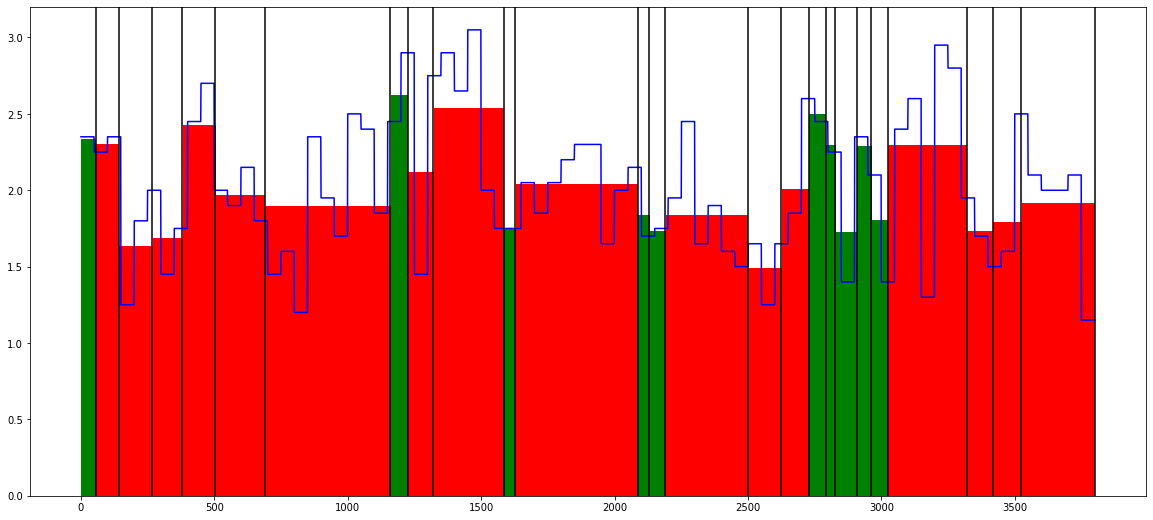

In [ ]:
fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, n_frame+1)), height=frame_seg_score1, width=1, color=color_coding(summary))
#plt.plot(pred)
#plt.plot(gt_mode,c='yellow')
plt.plot(gt,c='blue')

for s in change_pts:
  plt.axvline(x=s[1], color='black')
#Black is gt from excel(Mean)
#Red is gt Mode
#Blue is Predicted


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

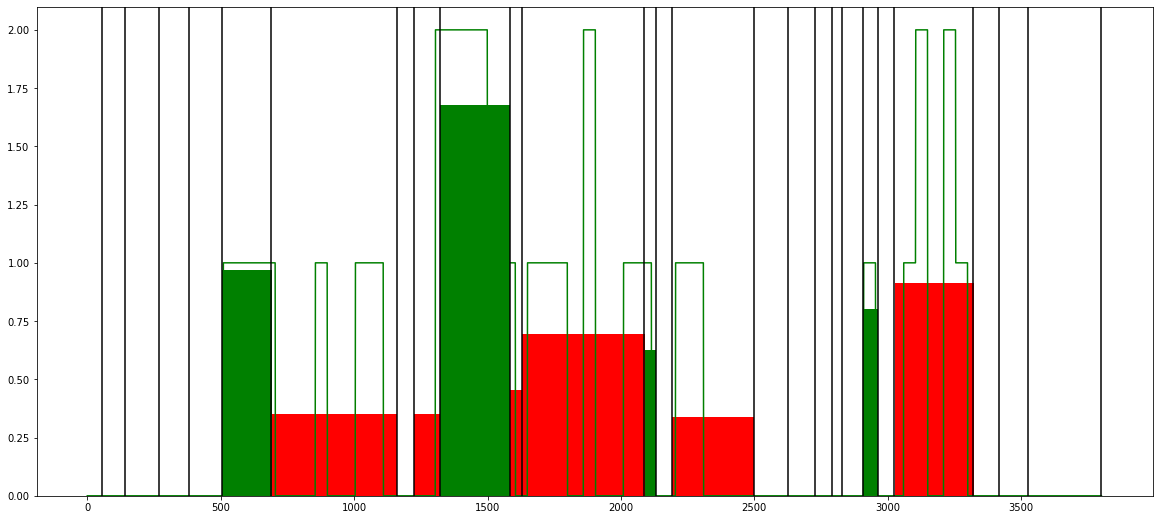

In [ ]:
frame_seg_score, summary=generate_summary3(gt_mode, change_pts, n_frame, nfps, picks)
plt.close
fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, n_frame+1)), height=frame_seg_score, width=1, color=color_coding(summary))
plt.plot(gt_mode,c='green')
for s in change_pts:
  plt.axvline(x=s[1], color='black')

In [ ]:
user=2

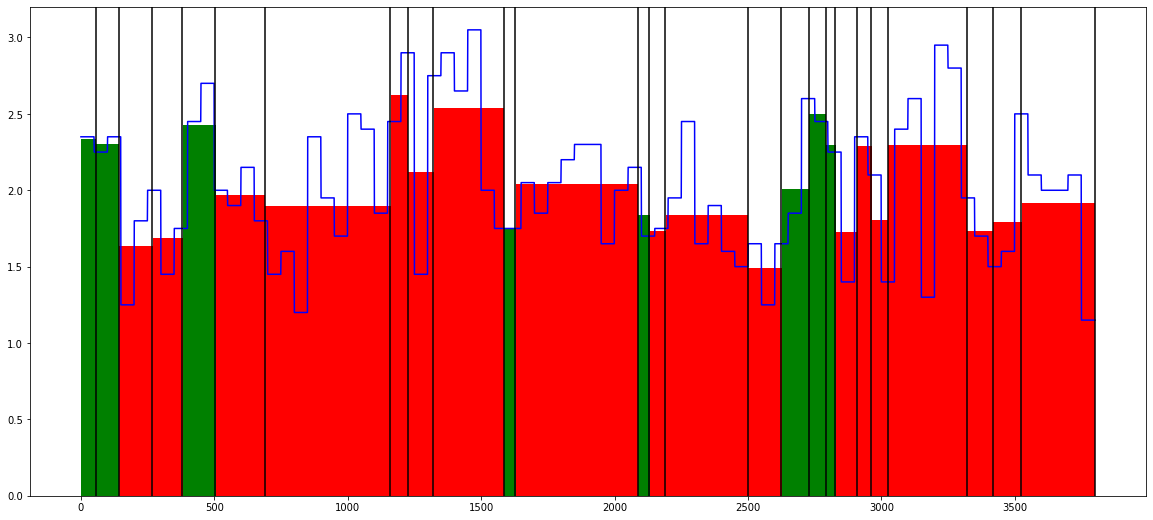

In [ ]:
fig = plt.figure(figsize = (20, 9))
plt.bar(x=list(range(1, n_frame+1)), height=frame_seg_score1, width=1, color=color_coding(file_load['video_'+str(v)]['user_summary'][:][user]))
#plt.plot(pred)
#plt.plot(gt_mode,c='yellow')
plt.plot(gt,c='blue')

for s in change_pts:
  plt.axvline(x=s[1], color='black')
#Black is gt from excel(Mean)
#Red is gt Mode
#Blue is Predicted
